# Métodos conservativos

Resolvemos la ecuación de Burgers (y la ecuación de advección) usando el método KT2 (Kurganov_Tadmor de orden 2) y MP5 (monotonicity preserving 5).

In [1]:
#using DiffEqOperators
using OrdinaryDiffEq
#using DifferentialEquations

In [2]:
using Plots

Aquí decidimos la ecuación a resolver. Esto será utilizado a la hora de elegir la función `Flux_x!` más adelante.

In [361]:
# Definición de symbolos
problem = :advection
#problem = :burgers

:advection

Incluimos las implementaciones numéricas de los métodos junto con algunas funciones auxiliares

In [15]:
include("../../../modules/module_choques_utils.jl") # todas las funciones necesarias
include("../../../modules/module_crash_conservatives_methods.jl") # todas las funciones necesarias

resolveEDO (generic function with 1 method)

Aquí puede elegir si usar Kurganov-Tadmor o MP5

In [363]:
KurganovTadmor = false          # KT2
MonotonicityPreserving5 = true  # MP5

true

Definimos la velocidad máxima de propagación. Esto es necesario para ajustar la disipación del método, así como garantizar estabilidad. Lo que importa es tener una cota inferior para la velocidad máxima de propagación de ondas en cualquier punto.

In [364]:
#Velocidad máxima de propagación

function advectionspeed(U, c)
    return abs(c)
end

function burgersspeed(U, c)
    return maximum(abs, U)  #no encuentro forma de escribir esto sin que aloque memoria...
end

if problem == :advection
    SpeedMax = advectionspeed
elseif problem == :burgers
    SpeedMax = burgersspeed
end

advectionspeed (generic function with 1 method)

Aquí damos la función ```Flux_x!```. Recuerde que estamos resolviendo problemas del tipo 

$$ u_t = F(u)_x$$

In [365]:
#Flujos
function advection!(F, U, c)
    @. F = c*U
end

function burgers!(F, U, Fpars)
    @. F = 0.5*U*U
end

if problem == :advection
    Flux_x! = advection!
elseif problem == :burgers
    Flux_x! = burgers!
end

advection! (generic function with 1 method)

Ahora empezamos a construir finalmente el problema. Primero definimos el intervalo espacial y temporal, junto con el vector donde guardaremos la solución. También elegimos algunos parámetros del problema.

In [366]:
N = 2000
N_FIELDS = 1

start = 0.0
stop = 2.0*pi
x = range(start, stop =stop, length = N+1)[1:end-1] #de manera que no incluya el último punto
dx = Float64(x.step)  #Δx
h = 1.0/dx
#Inicializamos el dato
u = Array{Float64}(undef, N, N_FIELDS)
du = copy(u)
@. u[:,1] = 0.5 + sin(x)

#Definimos el intervalo de integración y el paso dt
T = 2.0
tspan = (0.0, T)

#CFL = dt/dx
CFL = 0.1
dt = dx * CFL

#Parámetros del problema
if problem == :advection
    eqpars = 1.0
elseif problem == :burgers
    eqpars = false
end

1.0

Aquí elegimos el método de resolucion espacial, y preparamos la tupla `par` para integrar más adelante. Varias de estas funciones están definidas en `choques_utils.jl`

In [367]:
#Elegimos el método que queremos ver
if KurganovTadmor == true
    θ = 2.0  #Este valor tiene que estar entre 1 y 2. Mientras más cerca de 2, menor disipación.
             #Para sistemas de ecuaciones es mejor que esté más cerca de 1 para evitar oscilaciones.
    auxvectors = createKTauxvectors(N_FIELDS)
    scheme! = KT!
    par = (eqpars, h, θ, Flux_x!, SpeedMax, N, N_FIELDS, auxvectors)
    println("Elegido el método KT")
elseif MonotonicityPreserving5 == true
    auxvectors = createMP5auxvectors(N_FIELDS)
    scheme! = mp5!
    par = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectors)
    println("Elegido el método MP5")
end

Elegido el método MP5


La solución es una matriz de tamaño `N*N_Fields`. Para los problemas escalares esto quiere decir que son escencialmente un vector de una única columna, pero puede probar con sistemas de ecuaciones y funcionará igual.
Recuerde que para analizar convergencia es conveniente tomar datos iniciales que sean suaves y que sean polinómicos a trozos.

Ahora estamos en condiciones de definir los problemas, elegir integradores y fijar su comportamiento. Aquí es importante elegir un integrador estable, es decir uno cuya región de estabilidad incluya parte del eje imaginario, y preferentemente que sea TVD (Total Variation Diminishing). En nuestro caso eligiremos el integrador Runge Kutta `SSPRK33`, que es de tercer orden en el tiempo y es TVD.

In [368]:
prob = ODEProblem(scheme!,u,tspan,par);

In [369]:
# SSPRK33 de que no aparazca nuevas oscilaciones en la solución

sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100); # Esto es un método TVD
#@benchmark sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100) # Esto es un método TVD

retcode: Success
Interpolation: 1st order linear
t: 101-element Vector{Float64}:
 0.0
 0.02
 0.04
 0.06
 0.08
 0.1
 0.12
 0.14
 0.16
 0.18
 ⋮
 1.84
 1.86
 1.88
 1.9
 1.92
 1.94
 1.96
 1.98
 2.0
u: 101-element Vector{Matrix{Float64}}:
 [0.5; 0.5031415874858796; … ; 0.4937168560344412; 0.4968584125141204;;]
 [0.48000133330743233; 0.48314239118614155; … ; 0.47371984068533785; 0.47686047280748933;;]
 [0.46001066581373345; 0.46314993770400187; … ; 0.45373333704840085; 0.4568717886020494;;]
 [0.44003599352062983; 0.4431722237555561; … ; 0.43376533945987045; 0.4369003551062397;;]
 [0.42008530603159755; 0.4232172401609042; … ; 0.4138238348534227; 0.41695416062805646;;]
 [0.40016658335352573; 0.40329296864532005; … ; 0.39391679956292636; 0.3970411833772486;;]
 [0.3802877927112338; 0.38340737865308333; … ; 0.3740521961383963; 0.3771693882805407;;]
 [0.3604568853565436; 0.363568424155665; … ; 0.35423797015695374; 0.3573467237916265;;]
 [0.34068179338610094; 0.3437840404684626; … ; 0.3344820470429

In [17]:
sol,x,dx,dt = resolveEDO(:advection,:MonotonicityPreserving5,SSPRK33,2000,(0.0,2π),2.0);

Elegida la ecuación de Advección
Elegido el método MP5


Una vez que tenemos la solución, podemos analizarla. Aquí mostramos cómo graficarla.

In [8]:
using Printf

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/tareas/04_tarea/burgers_sin.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/tareas/04_tarea/burgers_sin.gif")
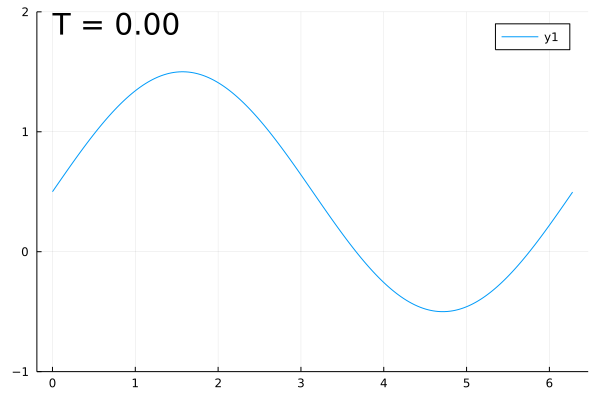

In [14]:
anim = @animate for t in sol.t
    plt = plot(x, sol(t), ylims = (-1.0,2.0))
    annotate!(plt, 0.0, 1.9, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "burgers_sin.gif", fps = 30)

### Ayuda para analizar convergencia en KT
Para el método MP5 puede analizar la covnergencia utilizando la norma $L_1$. Para el método de Kurganov-Tadmor, deberá utilizar la norma $Lip'$. Le daremos la implementación de esta norma y cómo utilizarla para calcular el factor $Q$.

In [372]:
# Norma Lipshit prime
function Lipprime(u, dx)
    pr = zeros(size(u)[1])
    for i in 2:size(u)[1]
        pr[i] = pr[i-1] + (u[i]+u[i-1])*dx
    end
    return sum(abs.(pr))*dx
end
function QKT(t, sol1, sol2, sol4, dx1, dx2)
    n1 = Lipprime(sol1(t)[:,1]-sol2(t)[1:2:end,1], dx1)
    n2 = Lipprime(sol2(t)[:,1]-sol4(t)[1:2:end,1], dx2)
    return log2(n1/n2)
end

QKT (generic function with 1 method)

In [373]:
sol = solve(prob,SSPRK33(),dt=dt);

### creamos operador de diferencias finitas con PBC

In [383]:
function D2_pbc(du,u,dx)
    @. du[2:end-1] = (u[3:end] - u[1:end-2])/(2*dx)
    du[1] = (u[2] - u[end])/(2*dx)
    du[end] = (u[1] - u[end-1])/(2*dx)
    return du
end

D2_pbc (generic function with 1 method)

### creamos operador de diferencias finitas sin cond. borde

Link útil: [https://en.wikipedia.org/wiki/Finite_difference_coefficient#Forward_finite_difference](https://en.wikipedia.org/wiki/Finite_difference_coefficient#Forward_finite_difference)

In [384]:
function D2(du,u,dt)
    @. du[2:end-1] = (u[3:end] - u[1:end-2])/(2*dt) # centered 2nd order
    du[1] = (-1.5*u[1]+2.0*u[2]-0.5*u[3])/dt  # forward 2nd order
    du[end] = (1.5*u[end]-2.0*u[end-1]+0.5*u[end-2])/dt # backward 2nd order
    return du
end

D2 (generic function with 1 method)

Verificamos que los operadores de diferencias finitas funcionan bien para funciones conocidas

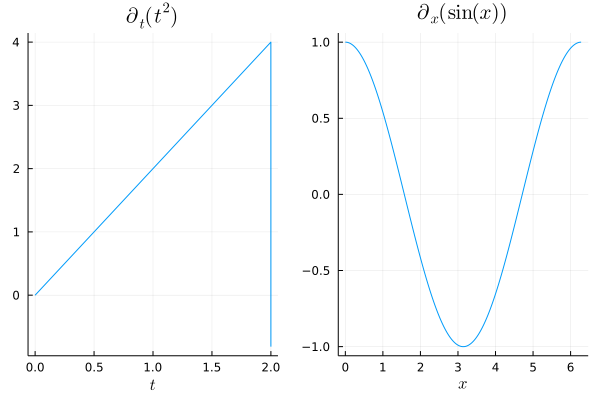

In [385]:
# probamos operador sin cond. borde
func_t = sol.t.^2;
∂func_t = zeros(length(sol.t))
∂func_t = D2(∂func_t,func_t,dt)

# probamos operador con PBC
func_x = sin.(x);
∂func_x = zeros(length(x))
∂func_x = D2_pbc(∂func_x,func_x,dx)

# ploteamos
plot1=plot!(plot(),sol.t,∂func_t,title="\$ \\partial_t(t^2) \$",label="",xlabel="\$t\$")
plot2=plot!(plot(),x,∂func_x,title="\$ \\partial_x(\\sin(x)) \$",label="",xlabel="\$x\$")
plot(plot1,plot2,layout=2)


### Creamos una función que permite calcular la velocidad de la ecuación de advección

In [386]:
function velocity_advection(sol,x,Δt,Δx)
    
    dim_row=length(sol.t)
    dim_column=length(x)

    # creamos y seteamos valores de la matriz
    u_matrix = zeros(dim_row,dim_column)
    for (t_index,t_value) in enumerate(sol.t)
        # c/fila corresponde a u(x,t) para un t fijo y ∀x
        u_matrix[t_index,:] = sol(t_value)[:]
    end

    # creamos y seteamos valores de matriz
    x_diff_matrix = zeros(dim_row,dim_column)
    for t_index in 1:dim_row
        # c/fila corresponde a ∂ₓ[u(x,t)] para un t fijo y ∀x con PBC
        x_diff_matrix[t_index,:] = D2_pbc(x_diff_matrix[t_index,:],u_matrix[t_index,:],Δx)
    end
    
    # creamos y seteamos valores de matriz
    t_diff_matrix = zeros(dim_row,dim_column)
    for x_index in 1:dim_column
        # c/fila corresponde a ∂ₜ[u(x,t)] para un x fijo y ∀t sin cond. borde
        t_diff_matrix[:,x_index] = D2(t_diff_matrix[:,x_index],u_matrix[:,x_index],Δt)
    end

    # creamos y seteamos valores de matriz
    F_matrix = zeros(dim_row,dim_column)
    # c/elemento corresponde a ∂ₜ[u(x,t)]/∂ₓ[u(x,t)]
    F_matrix .= -1.0 .* (t_diff_matrix ./ x_diff_matrix)
    return F_matrix
end

velocity_advection (generic function with 1 method)

In [387]:
velocity = velocity_advection(sol,x,dt,dx)

6368×2000 Matrix{Float64}:
  1.0        1.0        1.0       …   1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0        1.0       …   1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  ⋮                               ⋱                        
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0        1.0       …   1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0        1.0           1.0        1.0        1.0
  1.0        1.0 

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/tareas/04_tarea/velocidad.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/tareas/04_tarea/velocidad.gif")
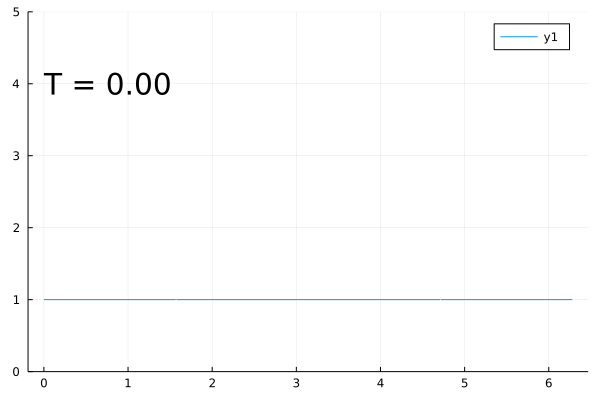

In [389]:
ymin=0;ymax=5;
anim = @animate for t_index in 1:10:length(sol.t)
    plt=plot(x,velocity[t_index,:],ylims = (ymin,ymax))
    # plt=plot(x,velocity[t_index,:])
    annotate!(plt, 0.0, 4, text("T = $(@sprintf("%.2f",t_index*dt))", :black, :left, 20))
end

gif(anim, "velocidad.gif", fps = 30)